In [157]:
import pandas as pd
import numpy as np

embeddings = pd.DataFrame(np.load('./data/embeddings.npy'))
review = pd.read_csv('./data/clean-sample.csv')
sentiment = pd.read_csv('./data/sentiments.csv')

# Word Embedding Clustering with TSNE

In [158]:
from sklearn.manifold import TSNE

sample = 2000

test_embeddings = embeddings.head(sample)

tsne = TSNE(n_components=3, learning_rate=100, random_state=42, perplexity=50)
tsne_embeddings = tsne.fit_transform(test_embeddings)

In [159]:
tsne_embeddings

array([[-26.948608  ,  17.903503  ,  13.883337  ],
       [ 20.744804  , -12.386017  ,  -0.10493327],
       [ -4.4913955 ,  12.213634  ,  16.174175  ],
       ...,
       [ 12.029176  ,  -9.585209  ,  10.882731  ],
       [ -0.6267919 ,  18.247856  ,  20.612974  ],
       [  2.2954862 , -15.756935  ,   8.840489  ]], dtype=float32)

In [160]:
tsne_embeddings_df = pd.DataFrame(tsne_embeddings, columns=['TSNE1', 'TSNE2', 'TSNE3'])

tsne_embeddings_df['text'] = review['text'].head(sample)
tsne_embeddings_df['stars'] = review['stars'].head(sample)
tsne_embeddings_df['general_category'] = review['general_category'].head(sample)
tsne_embeddings_df['sentiment'] = sentiment['sentiment'].head(sample)
tsne_embeddings_df['review'] = tsne_embeddings_df['text'].apply(lambda x: x[:10] + '...' if len(x) > 10 else x)

In [161]:
tsne_embeddings_df

,TSNE1,TSNE2,TSNE3,text,stars,general_category,sentiment,review
0,-26.948608,17.903503,13.883337,I tried to give this company the benefit of th...,1.0,Other,0.242703,I tried to...
1,20.744804,-12.386017,-0.104933,We ended up here through serendipity... White ...,5.0,Restaurant,0.324215,We ended u...
2,-4.491395,12.213634,16.174175,Bouncers were actively enforcing CDC/ social d...,5.0,Restaurant,0.184383,Bouncers w...
3,38.296318,2.337447,18.704393,Its a place that I comfortable but I hate when...,2.0,Restaurant,0.134130,Its a plac...
4,8.598813,-26.514107,-2.832615,Great food and great staff! There racks Mack b...,5.0,Restaurant,0.418598,Great food...
...,...,...,...,...,...,...,...,...
1995,-31.959501,14.803371,11.257952,Very shady. My 72 year old mother had a leaki...,1.0,Home_Services,0.203754,Very shady...
1996,-19.006504,3.353254,-12.562190,Fabulous people. I've been here 3 times and s...,5.0,Shopping,0.212681,Fabulous p...
1997,12.029176,-9.585209,10.882731,Food was awesome. The oysters were great. Five...,5.0,Restaurant,0.298674,Food was a...
1998,-0.626792,18.247856,20.612974,Been there a couple times before and both expe...,2.0,Other,0.291007,Been there...


In [162]:
import plotly.express as px

fig = px.scatter_3d(tsne_embeddings_df, x='TSNE1', y='TSNE2', z='TSNE3',
                    hover_data=['review', 'general_category', 'stars', 'sentiment'])

fig.show()

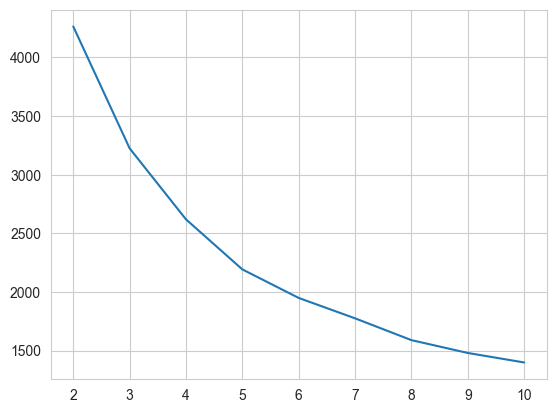

In [163]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
cluster_data = tsne_embeddings_df[['TSNE1', 'TSNE2', 'TSNE3']]
cluster_data = scaler.fit_transform(cluster_data)
cluster_data = pd.DataFrame(cluster_data, columns=['TSNE1_scaled', 'TSNE2_scaled', 'TSNE3_scaled'])

tsne_embeddings_df['TSNE1_scaled'] = cluster_data['TSNE1_scaled']
tsne_embeddings_df['TSNE2_scaled'] = cluster_data['TSNE2_scaled']
tsne_embeddings_df['TSNE3_scaled'] = cluster_data['TSNE3_scaled']


inertias = []
ks = range(2, 11)

for k in ks:
  kmeans_result = (KMeans(n_clusters=k, random_state=42, n_init='auto').fit(cluster_data))
  inertias.append(kmeans_result.inertia_)
  
sns.lineplot(x=ks, y=inertias)
plt.show()

In [164]:
kmeans = KMeans(n_clusters=5, n_init='auto')
kmeans.fit(cluster_data)
tsne_embeddings_df['cluster'] = kmeans.predict(cluster_data)

cluster_centers = kmeans.cluster_centers_

In [165]:
import plotly.graph_objects as go

fig = px.scatter_3d(tsne_embeddings_df, x='TSNE1_scaled', y='TSNE2_scaled', z='TSNE3_scaled', color='cluster',
                    hover_data=['review', 'general_category', 'stars', 'sentiment'])

# # Draw planes between clusters
# for i in range(len(cluster_centers)):
#     center = cluster_centers[i]
#     normal = np.cross(cluster_centers[(i+1)%len(cluster_centers)] - center,
#                       cluster_centers[(i+2)%len(cluster_centers)] - center)
#     normal /= np.linalg.norm(normal)  # Normalize the normal vector
# 
#     # Create a grid of points in the plane
#     x_range = np.linspace(tsne_embeddings_df['TSNE1_scaled'].min(), tsne_embeddings_df['TSNE1_scaled'].max(), 50)
#     y_range = np.linspace(tsne_embeddings_df['TSNE2_scaled'].min(), tsne_embeddings_df['TSNE2_scaled'].max(), 50)
#     X, Y = np.meshgrid(x_range, y_range)
#     Z = (-normal[0] * X - normal[1] * Y - np.dot(normal, center)) / normal[2]
# 
#     # Add the plane to the plot
#     fig.add_trace(go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.5))
# 
# # Customize the plot (optional)
# fig.update_layout(
#     title='Review Clusters with Decision Boundaries',
#     scene=dict(
#         xaxis_title='t-SNE Component 1',
#         yaxis_title='t-SNE Component 2',
#         zaxis_title='t-SNE Component 3'
#     )
# )

fig.show()

In [166]:
tsne_embeddings_df.groupby('cluster').describe()

TSNE1                                                         \
         count       mean        std        min        25%        50%   
cluster                                                                 
0        490.0  24.130840  10.549080   0.135958  15.784038  24.234660   
1        361.0   8.176092  11.555362 -19.778227   0.154733   6.841790   
2        445.0 -11.719691  13.161220 -38.971840 -22.813562 -10.839778   
3        350.0 -23.118793  10.038328 -41.448734 -31.098598 -24.612926   
4        354.0  -3.148009  13.444698 -31.978964 -13.591239  -5.047254   

                               TSNE2             ... TSNE2_scaled            \
               75%        max  count       mean  ...          75%       max   
cluster                                          ...                          
0        32.402903  47.200672  490.0   5.203740  ...     0.854547  1.968621   
1        16.449905  35.937172  361.0  -9.986978  ...    -0.232967  1.018884   
2        -0.828685  16.386818  445.0  14.111691  ...     1.489458  2.289478   
3       -16.681112   4.109739  350.0   0.888030  ...     0.565719  1.751547   
4         6.182074  30.989769  354.0 -16.226025  ...    -0.733772 -0.095188   

        TSNE3_scaled                                                    \
               count      mean       std       min       25%       50%   
cluster                                                                  
0              490.0  0.243684  0.704231 -1.422968 -0.266483  0.224566   
1              361.0 -1.286966  0.548437 -2.456573 -1.705737 -1.301050   
2              445.0  0.888585  0.582616 -0.729871  0.477273  0.901340   
3              350.0 -0.696249  0.564115 -2.006617 -1.091656 -0.662328   
4              354.0  0.546488  0.615341 -0.761157  0.073504  0.466771   

                             
              75%       max  
cluster                      
0        0.764444  2.084975  
1       -0.842611 -0.126107  
2        1.308357  2.208516  
3       -0.282477  0.600427  
4        0.992787  2.218352  

[5 rows x 64 columns]

# Scaled "Supervised" Clustering using stars, sentiment, and category (embedded)

In [167]:
category_embeddings = pd.DataFrame(np.load('./data/category_embeddings.npy'))

In [168]:
category_tsne = TSNE(n_components=1, learning_rate=10, perplexity=50, random_state=42)
categorical_tsne = category_tsne.fit_transform(category_embeddings.head(sample))

tsne_embeddings_df['category_component'] = categorical_tsne

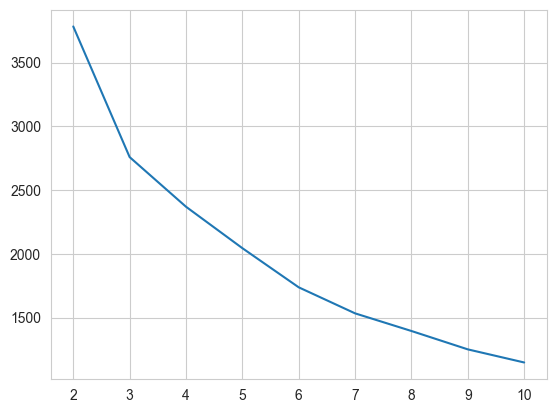

In [169]:
supervised_cluster_data = tsne_embeddings_df[['stars', 'sentiment', 'category_component']]
scaled_supervised_cluster_data = scaler.fit_transform(supervised_cluster_data)
scaled_supervised_cluster_data = pd.DataFrame(scaled_supervised_cluster_data, columns=['stars_scaled', 'sentiment_scaled', 'category_component_scaled'])

tsne_embeddings_df['stars_scaled'] = scaled_supervised_cluster_data['stars_scaled']
tsne_embeddings_df['sentiment_scaled'] = scaled_supervised_cluster_data['sentiment_scaled']
tsne_embeddings_df['category_component_scaled'] = scaled_supervised_cluster_data['category_component_scaled']

inertias = []
ks = range(2, 11)

for k in ks:
  kmeans_result = (KMeans(n_clusters=k, random_state=42, n_init='auto').fit(scaled_supervised_cluster_data))
  inertias.append(kmeans_result.inertia_)
  
sns.lineplot(x=ks, y=inertias)
plt.show()

In [170]:
scaled_kmeans_category = KMeans(n_clusters=3, n_init='auto')
scaled_kmeans_category.fit(scaled_supervised_cluster_data)
tsne_embeddings_df['scaled_supervised_cluster'] = kmeans_category.predict(scaled_supervised_cluster_data)

scaled_supervised_cluster_centers = kmeans_category.cluster_centers_

In [171]:
fig = px.scatter_3d(tsne_embeddings_df, x='stars_scaled', y='sentiment_scaled', z='category_component_scaled', color='scaled_supervised_cluster',
                    hover_data=['review', 'general_category', 'stars', 'sentiment'])

# # Draw planes between clusters
# for i in range(len(cluster_centers)):
#     center = cluster_centers[i]
#     normal = np.cross(cluster_centers[(i+1)%len(cluster_centers)] - center,
#                       cluster_centers[(i+2)%len(cluster_centers)] - center)
#     normal /= np.linalg.norm(normal)  # Normalize the normal vector
# 
#     # Create a grid of points in the plane
#     x_range = np.linspace(tsne_embeddings_df['stars_scaled'].min(), tsne_embeddings_df['stars_scaled'].max(), 50)
#     y_range = np.linspace(tsne_embeddings_df['category_component_scaled'].min(), tsne_embeddings_df['category_component_scaled'].max(), 50)
#     X, Y = np.meshgrid(x_range, y_range)
#     Z = (-normal[0] * X - normal[1] * Y - np.dot(normal, center)) / normal[2]
# 
#     # Add the plane to the plot
#     fig.add_trace(go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.5))
# 
# # Customize the plot (optional)
# fig.update_layout(
#     title='Review Clusters with Decision Boundaries',
#     scene=dict(
#         xaxis_title='t-SNE Component 1',
#         yaxis_title='t-SNE Component 2',
#         zaxis_title='t-SNE Component 3'
#     )
# )

fig.show()

# Unscaled "Supervised" Clustering

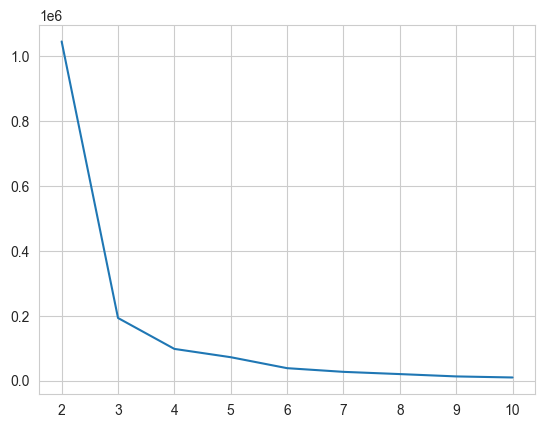

In [172]:
inertias = []
ks = range(2, 11)

for k in ks:
  kmeans_result = (KMeans(n_clusters=k, random_state=42, n_init='auto').fit(supervised_cluster_data))
  inertias.append(kmeans_result.inertia_)
  
sns.lineplot(x=ks, y=inertias)
plt.show()

In [175]:
kmeans_category = KMeans(n_clusters=10, n_init='auto')
kmeans_category.fit(supervised_cluster_data)
tsne_embeddings_df['supervised_cluster'] = kmeans_category.predict(supervised_cluster_data)

supervised_cluster_centers = kmeans_category.cluster_centers_

In [176]:
fig = px.scatter_3d(tsne_embeddings_df, x='stars', y='sentiment', z='category_component',
                    color='supervised_cluster',
                    hover_data=['review', 'general_category', 'stars', 'sentiment'])

# # Draw planes between clusters
# for i in range(len(cluster_centers)):
#     center = cluster_centers[i]
#     normal = np.cross(cluster_centers[(i+1)%len(cluster_centers)] - center,
#                       cluster_centers[(i+2)%len(cluster_centers)] - center)
#     normal /= np.linalg.norm(normal)  # Normalize the normal vector
# 
#     # Create a grid of points in the plane
#     x_range = np.linspace(tsne_embeddings_df['stars_scaled'].min(), tsne_embeddings_df['stars_scaled'].max(), 50)
#     y_range = np.linspace(tsne_embeddings_df['category_component_scaled'].min(), tsne_embeddings_df['category_component_scaled'].max(), 50)
#     X, Y = np.meshgrid(x_range, y_range)
#     Z = (-normal[0] * X - normal[1] * Y - np.dot(normal, center)) / normal[2]
# 
#     # Add the plane to the plot
#     fig.add_trace(go.Surface(x=X, y=Y, z=Z, colorscale='Viridis', opacity=0.5))
# 
# # Customize the plot (optional)
# fig.update_layout(
#     title='Review Clusters with Decision Boundaries',
#     scene=dict(
#         xaxis_title='t-SNE Component 1',
#         yaxis_title='t-SNE Component 2',
#         zaxis_title='t-SNE Component 3'
#     )
# )

fig.show()